In [1]:
%%capture --no-stdout
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import cna
np.random.seed(0)

# covarying neighborhood analysis tutorial

This notebook demonstrates the basic use of the `cna` python package. Before you run it, make sure you either install `cna` by running `pip install cna` or by cloning the `cna` github repo and adding it to your python path. (In the latter case you'll likely need to manually install the `multianndata` package, which is a dependency of `cna`.)

## table of contents:
1. [minimal working example](#first-section)
1. [processing data into the correct format](#second-section)
1. Additional CNA features: [additional results produced by cna's association function](#third-section)
1. Additional CNA features: [working directly with the NAM and NAM PCs](#fourth-section)

## 1. minimal working example <a class="anchor" id="first-section"></a>

Let's run `cna` and visualize results for a toy dataset in the commonly used `AnnData` format that already has a UMAP nearest-neighbor graph. You can learn more about data pre-processing and formatting in Section 2.

### 1.1 read in data

First, we'll read in the dataset and convert it to the format required for `cna`. This involves placing sample-level metadata in a dedicated pandas dataframe. (See Section 2 for more info)

In [2]:
# read in data
# NB: if data are already in MultiAnnData format (see section 2), they can be read via `cna.read`
#.    for example, try out: d = cna.read('data_multianndata.h5ad') instead of runnign this code block

import anndata as ad
d = ad.read_h5ad('data_anndata.h5ad')

from multianndata import MultiAnnData
d = MultiAnnData(d)
d.obs_to_sample(['case','male','batch'])

### 1.2 perform case/control analysis

In [3]:
# perform association test for case/ctrl status, controlling for sex as a covariate and accounting for potential batch effect
res = cna.tl.association(d,                   #dataset
            d.samplem.case,                   #sample-level attribute of intest (case/control status)
            covs=d.samplem[['male']],       #covariates to control for (in this case just one)
            batches=d.samplem.batch)        #batch assignments for each sample so that cna can account for batch effects

print('\nglobal association p-value:', res.p)

qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 16.40326205754668
	taking step 2
	median kurtosis: 12.75799245750447
	taking step 3
	median kurtosis: 6.1154849181504485
	taking step 4
	median kurtosis: 3.177490071480447
stopping after 4 steps
throwing out neighborhoods with batch kurtosis >= 6
keeping 10000 neighborhoods
covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median batch kurtosis =  1.981293621817167
computing SVD
performing association test


/data/srlab1/yakir/py/cna/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs

global association p-value: 0.000999000999000999


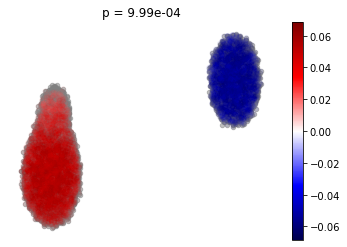

In [4]:
# visualize which populations are expanded or depleted among case samples relative to cntrls
cna.pl.umap_ncorr(d,                           #dataset
            res,                               #cna results object
            scatter0={'alpha':0.5, 's':20},    #plotting parameters for neighborhoods that pass FDR
            scatter1={'alpha':0.05, 's':20})   #plotting parameters for neighborhoods that don't pass FDR
plt.title('p = {:.2e}'.format(res.p))
plt.show()

In the plot above, each cell is colored according to its neighborhood coefficient, *i.e.*, color corresponds to the correlation of abundance in each cell's corresponding neighborhood to case/control status. Neighborhoods that don't pass FDR 5% are shown in gray. As this plot shows, cases have a greater abundance of cells from the left-hand cluster relative to controls.

### 1.3 analyze a more sophisticated phenotype

Let's next perform an association test for male/female sex rather than case/control status...

covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median batch kurtosis =  1.9949274142866247
computing SVD
performing association test
computing neighborhood-level FDRs


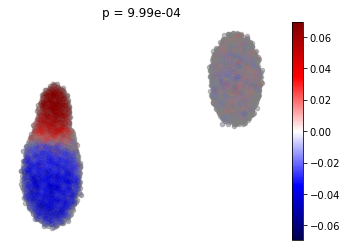

In [5]:
# perform association test for male/female sex
# we control for case/control status as a covariate and account for potential batch effects
res = cna.tl.association(d, d.samplem.male, covs=d.samplem[['case']], batches=d.samplem.batch)

# visualize the results
cna.pl.umap_ncorr(d, res,
            scatter0={'alpha':0.5, 's':20},
            scatter1={'alpha':0.05, 's':20})
plt.title('p = {:.2e}'.format(res.p))
plt.show()

It's now clear that a sub-population of the left-hand cluster is more abundant in males. CNA automatically picked up on this without needing to be given a resolution parameter.

Note that it looks like some cells in the right-hand cluster pass our FDR threshold of 5%. However, these cells comprise only ~6% of the cells that pass the threshold and so are likely false discoveries.

### 1.4 relate results to clusters

If this dataset had been clustered, two clusters would likely have been defined.

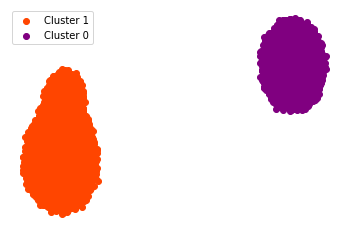

In [6]:
sc.tl.leiden(d, resolution = 0.1)
plt.scatter(*d.obsm['X_umap'][d.obs.leiden=='0'].T, c='orangered', label='Cluster 1')
plt.scatter(*d.obsm['X_umap'][d.obs.leiden=='1'].T, c='purple', label='Cluster 0')
plt.legend(); plt.axis('off')
plt.show()

We can examine within-cluster heterogeneity characterized by CNA by visualizing the distribution of neighborhood coefficients within each cluster.

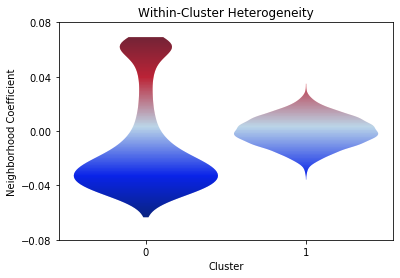

In [7]:
ax = cna.pl.violinplot(d,     # dataset
                  res,        # CNA results object
                  'leiden')   # name of the column of obs that contains the clustering
ax.set_title('Within-Cluster Heterogeneity')
ax.set_yticks([-0.08, -0.04, 0, 0.04, 0.08])
ax.set_xlabel('Cluster')
plt.show()

### 1.5 relate results to genes

To characterize the populations driving the association, we can examine per-gene correlations to neighborhood coefficient. These per-gene values may be informative on their own, or they could be further analyzed using techniques like gene set enrichment analysis.

In [8]:
# compute correlation between neighborhood coefficients and genes
d.var['corr_case'] = np.corrcoef(res.ncorrs.reshape(1,-1), d.X, rowvar=False)[0,1:]

In [9]:
# view top 5 most strongly correlated genes
d.var.sort_values('corr_case', ascending=False).head()

,corr_case
gene,
b'gene_10',0.186798
b'gene_9',0.181042
b'gene_4',0.179933
b'gene_11',0.179853
b'gene_1',0.173886


In [10]:
# view top 5 most negatively correlated genes
d.var.sort_values('corr_case', ascending=True).head()

,corr_case
gene,
b'gene_20',-0.100297
b'gene_21',-0.097420
b'gene_22',-0.089048
b'gene_14',-0.085773
b'gene_19',-0.079371


## 2. data formats and preprocessing <a class="anchor" id="second-section"></a>

Let's now understand better the data format used by `cna` and what pre-processing is necessary to run `cna`.

### 2.1 the `MultiAnnData` object

The data format used by `cna` a python object called `MultiAnnData`, which is a derivative of the common `AnnData` object used by `scanpy` that is modified to explicitly accommodate multi-sample single-cell datasets by including sample-level metadata.

There are three ways to create `MultiAnnData` objects. Reading from `h5ad` format using `cna.read`, conversion from an `AnnData` object, and manual construction.

#### 2.1.1 read a `MultiAnnData` object from a file

In [11]:
d = cna.read('data_multianndata.h5ad')

Like an `AnnData` object, the `MultiAnnData` object `d` stores raw data in `.X`, per-cell data in `.obs`, and per-marker data in `.var`.

However, `d` additional stores per-sample data in `d.samplem`. Let's take a look.

In [12]:
d.samplem.head()

,case,male,batch
id,,,
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,0,4


#### 2.1.2 build a `MultiAnnData` object from an `AnnData` object

The second way to create a `MultiAnnData` object is to create one from an `AnnData` object. In this case, you need to explicitly supply the sample-level metadata for `.samplem`. The easiest way to do this is typically to take this information from `.obs` if it is already stored there, as is often the case in single-cell datasets. Another option is to explicitly set `.samplem` to a `DataFrame` that's been manually created.

**Either way, `cna` needs to know which column of `.obs` contains the sample id of each cell. `cna` assumes that this columns is named `id`, but this behavior can be changed by passing `sampleid='someothername'` into the `MultiAnnData` function. The name of this column also needs to match the name of the index of `.samplem`.**

In [13]:
# read in AnnData object from h5ad file and convert it to MultiAnnData
d = ad.read_h5ad('data_anndata.h5ad')
d = MultiAnnData(d, sampleid='id') # the default value of sampleid is 'id', here we just repeat it for clarity
print('d.samplem has', len(d.samplem.columns), 'columns')

# Since our metadata are stored per-cell, we need to copy the information that is actually per-sampl
# (case status, batch and covariates) to the per-sample metadata DataFrame `d.samplem`
d.obs_to_sample(['case','male','batch'])
print('now d.samplem has', len(d.samplem.columns), 'columns')
d.samplem.head()

d.samplem has 0 columns
now d.samplem has 3 columns


,case,male,batch
id,,,
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,0,4


#### 2.1.3 build a `MultiAnnData` object manually

Building a `MultiAnnData` object manually works just like building an `AnnData` object manually. The main difference is that you also need to tell `cna` which column of `.obs` contains the sample id of each cell. **`cna` will assume that this column is named `id` unless it is told otherwise.**

In [14]:
import multianndata as mad

# let's pretend we had X, obs, and var as standalone objects...
X, obs, var = d.X, d.obs, d.var

# we can create a MultiAnnData object from these
d = mad.MultiAnnData(X=X,            # expression matrix
                     obs=obs,        # cell metadata matrix
                     sampleid='id')  # name of column of cell_meta that contains sample id for each cell
                                     #    default value is 'id' but we repeat here for clarity
# convert per-cell metadata into per-sample metadata as before
d.obs_to_sample(['batch', 'case', 'male'])

As above, if instead our raw metadata table already contained information per-sample, we could have created `d.samplem` directly.

### 2.2 pre-processing

The main pre-processing step that is required before running `cna` is to compute a cell-cell similarity graph. Here we'll use `scanpy` to compute the standard UMAP similarity graph. (In principle, any graph can be computed here.)

In [15]:
%%capture --no-stdout

# compute the UMAP cell-cell similarity graph
sc.pp.neighbors(d)

# compute UMAP coordinates for plotting
sc.tl.umap(d)

# the following line would save the pre-processed data as a h5ad file
# d.write('test.h5ad')

## 3. additional `cna` features

### 3.1 additional results produced by the `cna` `association` function <a class="anchor" id="third-section"></a>

Let's re-do the `cna` analysis for case status and go over the results in more detail

In [16]:
d = cna.read('data_multianndata.h5ad')
res = cna.tl.association(d, d.samplem.case, covs=d.samplem[['male']], batches=d.samplem.batch)

qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 16.40326205754668
	taking step 2
	median kurtosis: 12.75799245750447
	taking step 3
	median kurtosis: 6.1154849181504485
	taking step 4
	median kurtosis: 3.177490071480447
stopping after 4 steps
throwing out neighborhoods with batch kurtosis >= 6
keeping 10000 neighborhoods
covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median batch kurtosis =  1.981293621817167
computing SVD
performing association test


/data/srlab1/yakir/py/cna/cna/tools/_association.py:74: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs


The `res` object returned by the association function contains the following fields:
1. `p` is the global p-value for association
1. `k` is the number of NAM PCs used for the association test (automatically selected in a data-dependent way)
1. `ncorrs` is the vector of neighborhood coefficients
1. `fdr_10p_t` and `fdr_5p_t` contain the thresholds on `np.abs(ncorrs)` needed to provide FDRs of 10% and 5% respectively
1. `fdrs` contains information on neighborhood-level FDRs at other thresholds
1. `kept` is a boolean vector that specifies which cells passed qc. So, e.g., `ncorrs` is of length `kept.sum()`.
1. `r2` is the global prediction r-squared achieved by the model
1. `r2_perpc` is the prediction r-squared achieved by each pc on its own
1. `beta` is the coefficient vector, one coefficient per PC
1. `yresid` and `yresid_hat` are the phenotype and the predicted phenotype, both with covariates and batch residualized out

The kurtosis numbers in the output above say how 'outlier-y' the neighborhood abundances are at each step in the diffusion that `cna` does to define its neighborhoods. The algorithm stops when these numbers stop going down quickly. But if you see that `cna` stops when kurtosis is still very high (like above 10), that's likely a sign that the data aren't qc'd properly or are otherwise unsuitable.

### 3.2 working directly with the NAM and NAM PCs <a class="anchor" id="fourth-section"></a>

The association function above also automatically computes the NAM and its SVD as a prerequisite to the association testing. These can be found in the following objects
1. `d.uns['NAM.T']` contains the transpose of the NAM (neighborhoods by samples)
1. `d.uns['NAM_sampleXpc']` contains the sample loadings of the principal components of the NAM
1. `d.uns['NAM_nbhdXpc']` contains the neighborhood loadings of the principal components of the NAM
1. `d.uns['NAM_svs']` contains the squared singular values of the NAM

These objects can also be computed independent of any association test using the function `cna.tl.nam`, demonstrated below

In [17]:
cna.tl.nam(d, batches=d.samplem.batch) #note: this NAM is being computed *without* adjusting for sex or case/ctrl status

covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median batch kurtosis =  1.9949274142866247
computing SVD


Let's visualize a few of the results...

#### 3.2.1 neighborhood loadings of NAM PCs

First, we can plot the neighborhood loadings of each NAM PC to see which abundance patterns they capture

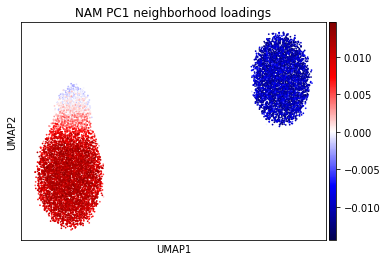

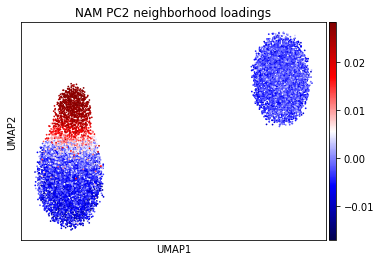

In [18]:
#plot neighborhood loadings of NAM PC 1
d.obs['NAMPC1'] = np.nan
d.obs.loc[d.uns['keptcells'], 'NAMPC1'] = d.uns['NAM_nbhdXpc'].PC1
sc.pl.umap(d, color='NAMPC1', cmap='seismic', title='NAM PC1 neighborhood loadings')
plt.show()

#plot neighborhood loadings of NAM PC 2
d.obs['NAMPC2'] = np.nan
d.obs.loc[d.uns['keptcells'], 'NAMPC2'] = d.uns['NAM_nbhdXpc'].PC2
sc.pl.umap(d, color='NAMPC2', cmap='seismic', title='NAM PC2 neighborhood loadings')
plt.show()

We can see here that NAM PC 1 primarily captures the extent to which a sample has cells in the left-hand cluster vs the right-hand cluster, and that NAM PC 2 primarily additionall captures the extent to which a sample has cells in the top of the left-hand cluster vs the bottom of the left-hand cluster.

#### 3.2.2 sample loadings of NAM PCs

We can also examine the sample loadings of each NAM PC to explicitly see which samples have high and low values of each NAM PC. Below we'll examine how this relates to the sample-level metadata in our toy dataset.

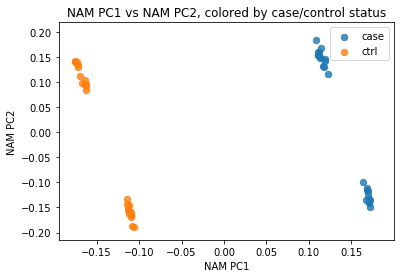

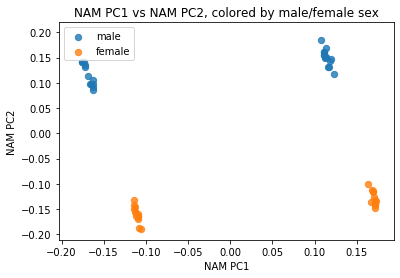

In [19]:
def sample_loading_plot_by_binary_pheno(pheno, case_label, ctrl_label): #assumes pheno is binary
    pcs = d.uns['NAM_sampleXpc']
    cases = pheno.astype(np.bool)
    plt.scatter(pcs.loc[cases].PC1, pcs.loc[cases].PC2, s=40, alpha=0.8, label=case_label)
    plt.scatter(pcs.loc[~cases].PC1, pcs.loc[~cases].PC2, s=40, alpha=0.8, label=ctrl_label)
    plt.legend()
    plt.xlabel('NAM PC1')
    plt.ylabel('NAM PC2')

#plot sample loadings of NAM PC1 versus NAM PC2, colored by case/control status
sample_loading_plot_by_binary_pheno(d.samplem.case, 'case', 'ctrl')
plt.title('NAM PC1 vs NAM PC2, colored by case/control status')
plt.show()

#plot sample loadings of NAM PC1 versus NAM PC2, colored by male/female sex
sample_loading_plot_by_binary_pheno(d.samplem.male, 'male', 'female')
plt.title('NAM PC1 vs NAM PC2, colored by male/female sex')
plt.show()

You can see in these plots that NAM PC 1 roughly corresponds to case/control status and NAM PC1 roughly corresponds to sex.

#### 3.2.3 variance explained by NAM PCs

Like ordinary PCs, each NAM PC also comes with a quantification of how much dataset-wide variance it explains. These are stored in the `NAM_svs` field. Let's visualize them in the traditional way below.

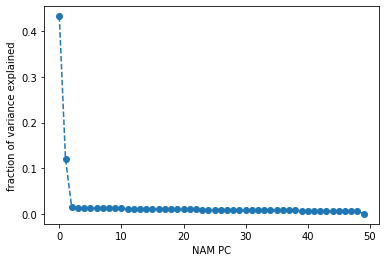

In [20]:
# plot variance explained by each NAM PC
plt.plot(d.uns['NAM_svs']/d.uns['NAM_svs'].sum(), marker='o', linestyle='--')
plt.xlabel('NAM PC')
plt.ylabel('fraction of variance explained')
plt.show()

As this plot demonstrates, PC1 explains ~40% of the variance in the dataset, PC2 explains ~12%, and the rest really don't contribute much.